<a href="https://colab.research.google.com/github/joylin0209/40133HW/blob/main/JoyLin_Hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 - Classifying Meanings & Documents (With Machine Learning)

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data.

In [3]:
# run if on Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-xnv9dddp
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-xnv9dddp
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done


# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain (We'll see how far Large Language Models can go). Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [5]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("/content/drive/MyDrive/SOCI40133/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [6]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [7]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [8]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [9]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


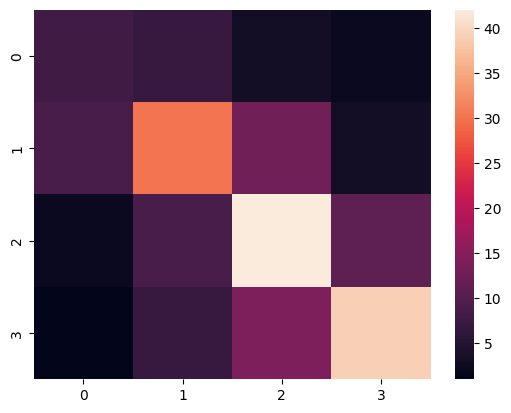

In [10]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [11]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [12]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [13]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [14]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [15]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


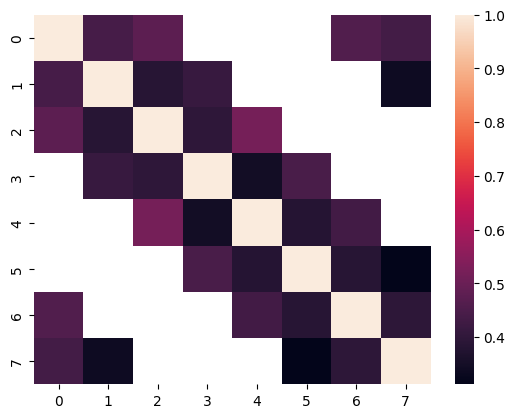

In [16]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others.

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [17]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [18]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [19]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

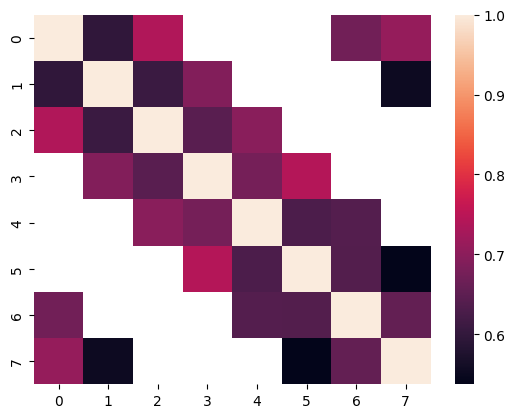

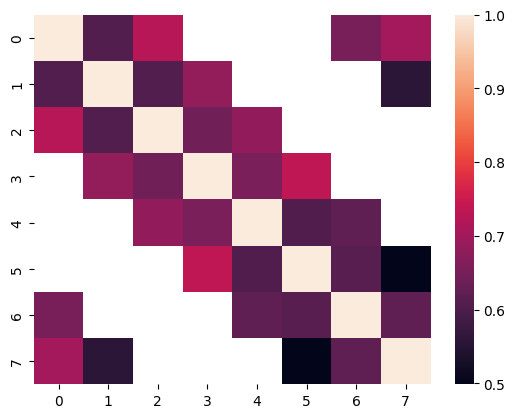

In [20]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [21]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [22]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"
ex1 = np.loadtxt("/content/drive/MyDrive/SOCI40133/testdata_irregular.txt")
annoex1 = AnnotationsContainer.from_array(ex1, missing_values=[-1])

In [23]:
annoex1.annotations

array([[ 4, -1,  3,  4,  4,  4],
       [ 4,  4,  4, -1,  4, -1],
       [ 0,  1,  0,  0, -1,  0],
       ...,
       [ 1,  0,  0,  0,  0,  0],
       [ 2,  2,  2,  1,  1,  2],
       [ 1,  2,  1,  2,  2,  3]])

In [24]:
annoex1.labels

[0.0, 1.0, 2.0, 3.0, 4.0]

In [25]:
annoex1.missing_values

[-1]

In [26]:
pyanno.measures.agreement.labels_frequency(annoex1.annotations,4)

array([0.24605215, 0.29342637, 0.14432611, 0.15460889, 0.16158649])

[[53. 30. 17.  2.]
 [29. 63. 15.  6.]
 [13. 18. 18. 11.]
 [ 1.  8.  8. 26.]]


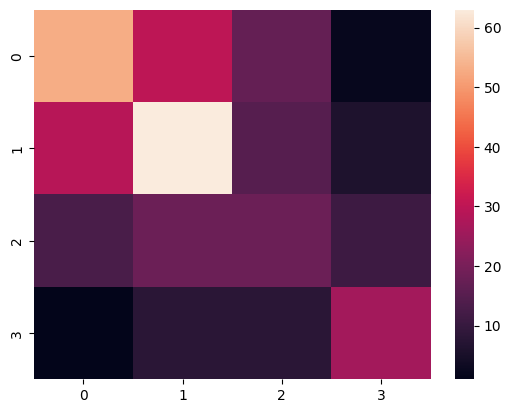

In [27]:
cex1 = pyanno.measures.agreement.confusion_matrix(annoex1.annotations[:,0], annoex1.annotations[:,1],4)
print(cex1)
ac = seaborn.heatmap(cex1)
plt.show()

In [28]:
scotts_pi(annoex1.annotations[:,0], annoex1.annotations[:,1])

0.3555736379310761

In [29]:
from pyanno.measures import fleiss_kappa

consistent_annotations = [item for item in annoex1.annotations if len(set(item)) == 1]

consistent_annotations_array = np.array(consistent_annotations)


kappa = fleiss_kappa(consistent_annotations_array)

print("Fleiss' Kappa:", kappa)


Fleiss' Kappa: 1.0


In [30]:
krippendorffs_alpha(annoex1.annotations[::])

0.7063582692224721

In [31]:
cohens_kappa(annoex1.annotations[:,0], annoex1.annotations[:,1])

0.3557556069671322

In [32]:
mex1 = pairwise_matrix(cohens_kappa, annoex1.annotations)
print(mex1)

[[1.         0.35575561 0.33698415 0.33523017 0.34737236 0.31948298]
 [0.35575561 1.         0.29761976 0.33505174 0.32945634 0.28732897]
 [0.33698415 0.29761976 1.         0.35444207 0.32247487 0.31940591]
 [0.33523017 0.33505174 0.35444207 1.         0.35071913 0.27669961]
 [0.34737236 0.32945634 0.32247487 0.35071913 1.         0.30304137]
 [0.31948298 0.28732897 0.31940591 0.27669961 0.30304137 1.        ]]


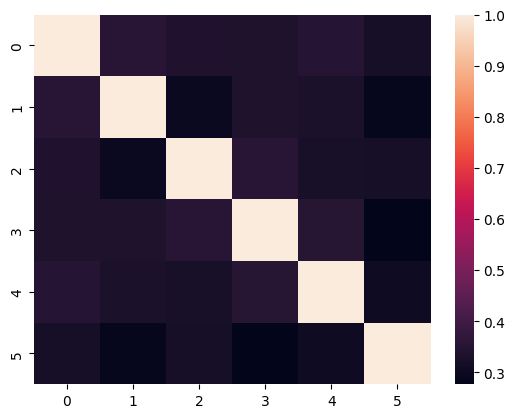

In [33]:
ax = seaborn.heatmap(mex1)
plt.show()

In [34]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, annoex1.annotations)

0.3247376695014875

In [35]:
cohens_weighted_kappa(annoex1.annotations[:,0], annoex1.annotations[:,1])

0.5637404376266756

In [36]:
pairwise_metric_average(cohens_weighted_kappa,annoex1.annotations)

0.5442764094598448

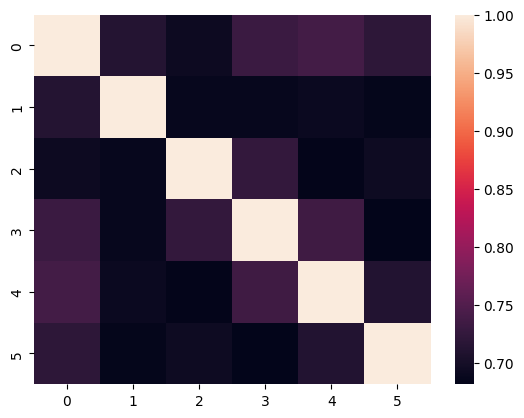

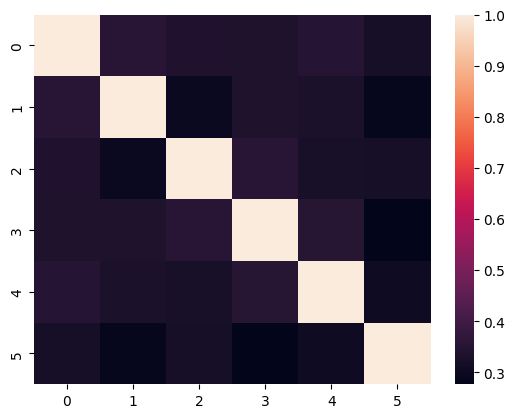

In [37]:
n = pairwise_matrix(pearsons_rho, annoex1.annotations)
m = pairwise_matrix(spearmans_rho, annoex1.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(mex1)
plt.show()

In [38]:
print(pairwise_metric_average(pearsons_rho,annoex1.annotations), pairwise_metric_average(spearmans_rho,annoex1.annotations))

0.7046465272481724 0.6756214583492312


# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`).

The four data patterns include:
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [39]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [40]:
noise = .2

numPerCategory = 500

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(numPerCategory), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)


We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [41]:
dfTrain

,vect,category
636,"[0.664901806035687, -0.657754403955747]",0
657,"[-0.816674934865474, 0.7214294213153647]",1
51,"[-0.05324874276729432, 0.7499364736208445]",1
892,"[0.5409359323558806, 0.7476173882811086]",0
288,"[0.5947936995272404, -0.7753744752023275]",0
...,...,...
194,"[0.6458454609614255, -0.375243035869429]",0
211,"[-0.11029848429815972, -0.028484361662326263]",1
389,"[-0.5610160961862992, -0.9243340933459021]",1
384,"[0.2327968705525847, -0.602521668139961]",0


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [42]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


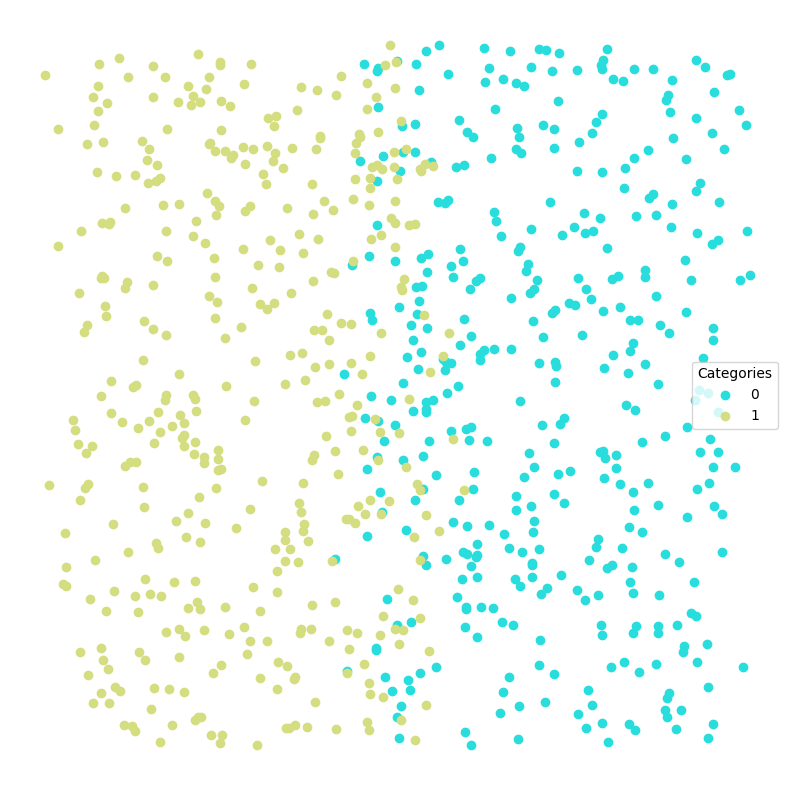

In [43]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [44]:
##Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [45]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [46]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

RandomForestClassifier()

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [47]:
dfTrain['vect']

636          [0.664901806035687, -0.657754403955747]
657         [-0.816674934865474, 0.7214294213153647]
51        [-0.05324874276729432, 0.7499364736208445]
892         [0.5409359323558806, 0.7476173882811086]
288        [0.5947936995272404, -0.7753744752023275]
                           ...                      
194         [0.6458454609614255, -0.375243035869429]
211    [-0.11029848429815972, -0.028484361662326263]
389       [-0.5610160961862992, -0.9243340933459021]
384         [0.2327968705525847, -0.602521668139961]
539        [-0.6690597090733784, 0.6119908401994743]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [48]:
np.stack(dfTrain['vect'])

array([[ 0.66490181, -0.6577544 ],
       [-0.81667493,  0.72142942],
       [-0.05324874,  0.74993647],
       ...,
       [-0.5610161 , -0.92433409],
       [ 0.23279687, -0.60252167],
       [-0.66905971,  0.61199084]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [49]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.885488,0.902913,0.857178,0.877358
1,0.115,0.885488,0.865979,0.823854,0.893617


This lets us look at which classes do better:

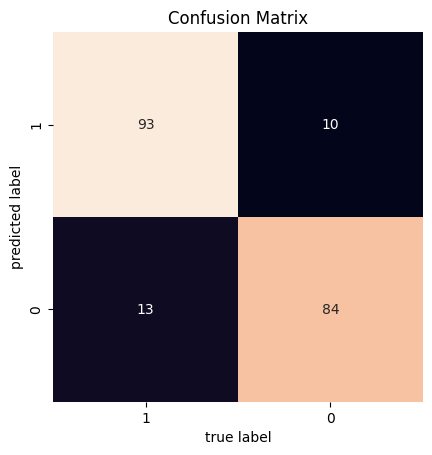

In [50]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

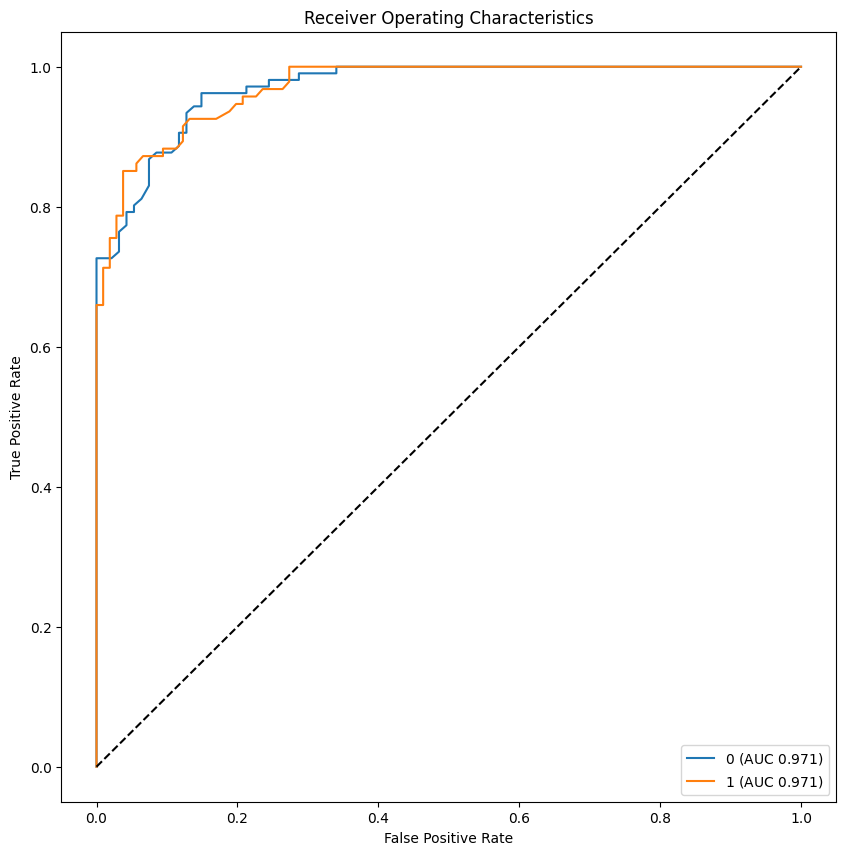

In [51]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


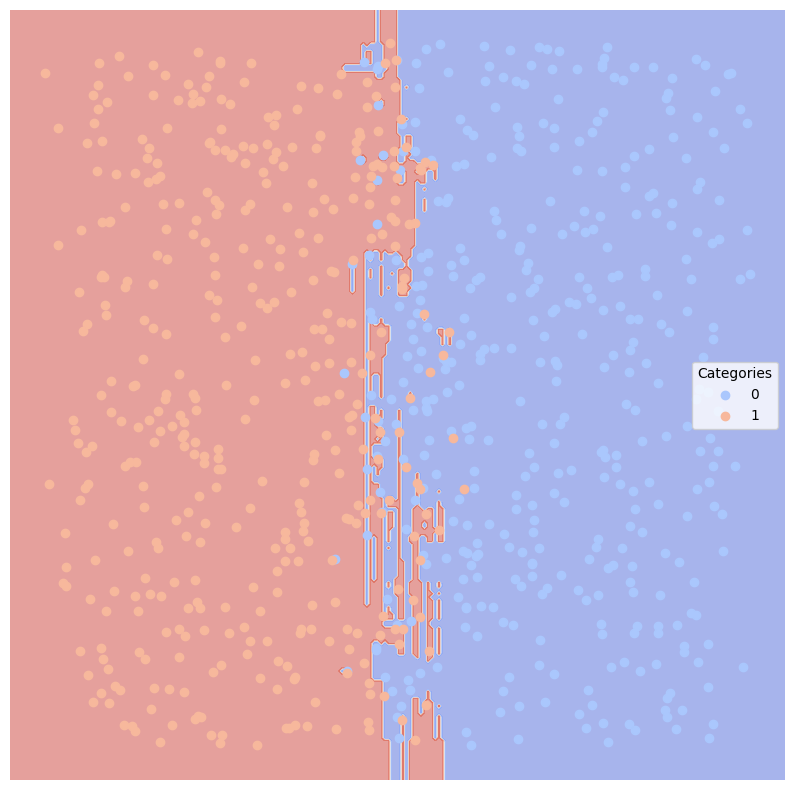

In [52]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter), you can set a `dataDirectory=` parameter in the loadReddit function to match the data folder path on Colab.

In [53]:
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='/content/drive/MyDrive/SOCI40133/data'), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='/content/drive/MyDrive/SOCI40133/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(dataDirectory='/content/drive/MyDrive/SOCI40133/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(dataDirectory='/content/drive/MyDrive/SOCI40133/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(dataDirectory='/content/drive/MyDrive/SOCI40133/data'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory='/content/drive/MyDrive/SOCI40133/data'), test_size=.2)

Loading Reddit data
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [54]:
dfTrain

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,category,tokenized_text,normalized_text,vect
146,146,phlogiston,False,3895,Tales From Tech Support,I thought I'd share one of my proudest moments...,"It doesn't matter what it costs, please get my...",https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[I, thought, I, 'd, share, one, of, my, proude...","[think, share, proudest, moment, bench, tech, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1003,1003,[deleted],False,142,Weeaboo Tales: stories about the extreme fans ...,"This is a strange thing to write about, and li...","""I'm half Japanese"" (X-post from/r/letsnotmeet)",https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[This, is, a, strange, thing, to, write, about...","[strange, thing, write, little, hard, explain,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1340,1340,ThisIsNotTammy,False,3086,Relationships,"I lied, this is Tammy. I am 23f and I have a...",My brother [22m] Pushed Me [23f] Into a Pool a...,https://www.reddit.com/r/relationships/comment...,Relationships,"[I, lied, this, is, Tammy, I, am, 23f, and, I,...","[lie, tammy, 23f, irish, twin, brock, m, brock...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
204,204,ThrashTitan,False,3388,Tales From Tech Support,Ticket comes in at 4pm on Friday; P2 level. Th...,This is a priority ticket and cannot wait unti...,https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[Ticket, comes, in, at, 4, pm, on, Friday, P2,...","[ticket, come, pm, friday, p2, level, high, pr...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1154,1154,apis_cerana,False,106,Weeaboo Tales: stories about the extreme fans ...,As an insecure 14-year old girl who was into m...,I'm Japanese and have dealt with many weebs in...,https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[As, an, insecure, 14, year, old, girl, who, w...","[insecure, year, old, girl, manga, go, con, co...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[This, just, happened, So, I, had, a, laptop, ...","[happen, laptop, system, board, fail, warranty...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
167,167,Lolucoca,False,3671,Tales From Tech Support,"Hi there, this is the tale of one of the most ...",I f'd up and now you're gonna get fired!,https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[Hi, there, this, is, the, tale, of, one, of, ...","[hi, tale, incompetent, owner, computer, repai...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
916,916,[deleted],False,184,Weeaboo Tales: stories about the extreme fans ...,"I run a convention based maid café, if you don...",My maid cafe creep horror story.,https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[I, run, a, convention, based, maid, café, if,...","[run, convention, base, maid, café, know, maid...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
477,477,[deleted],False,60,Bad Roommates: Tales of Irritation,Warning: Wall of text ahead. Also sorry about ...,I feel like the sex police.,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[Warning, Wall, of, text, ahead, Also, sorry, ...","[warn, wall, text, ahead, sorry, error, m, mob...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [55]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [56]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [57]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.009375,0.984793,0.986667,0.966952,0.973684
Tales From Tech Support,0.009375,0.990008,0.977528,0.969545,0.988636
Weeaboo Tales,0.006250,0.991735,0.987654,0.978586,0.987654
Relationships,0.006250,0.991293,0.986667,0.976636,0.986667


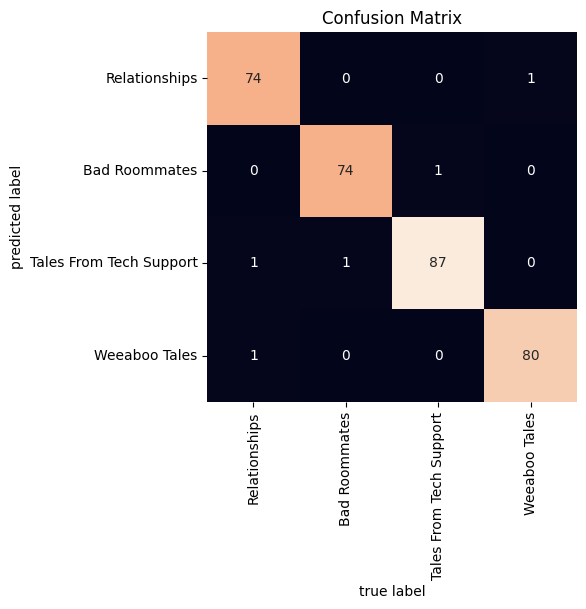

In [58]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

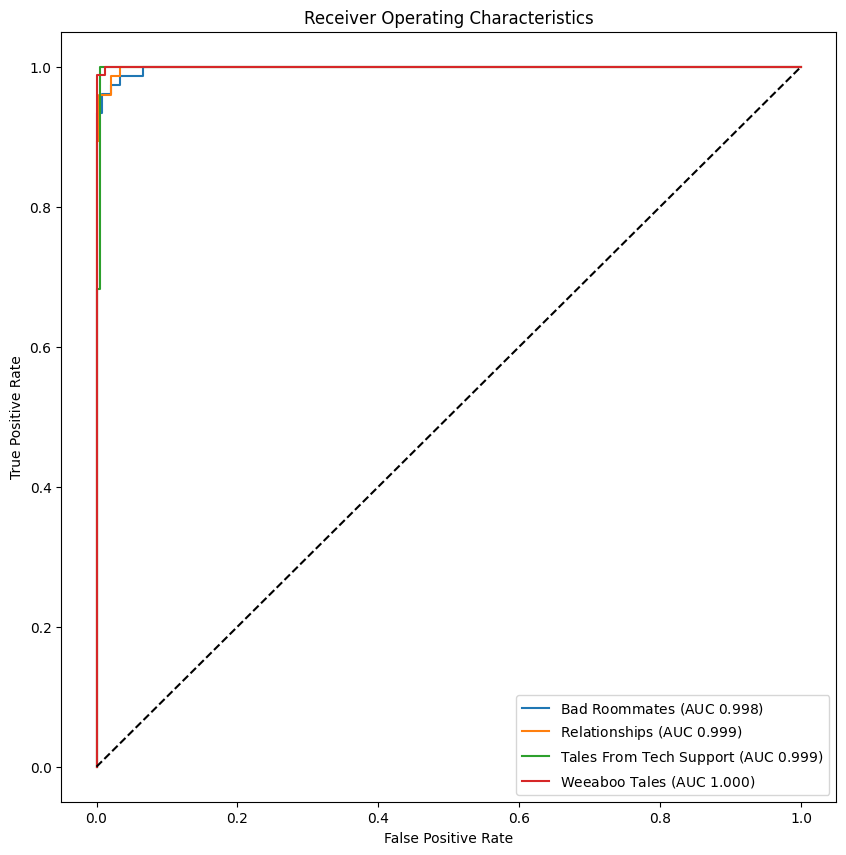

In [59]:
lucem_illud.plotMultiROC(clf, dfTest)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


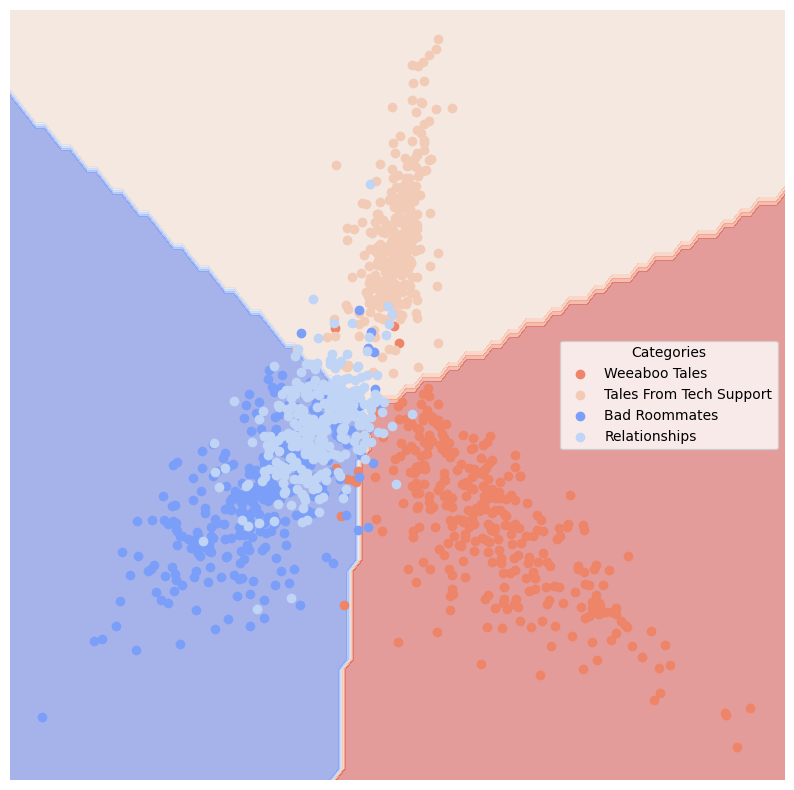

In [60]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [61]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)

In [62]:
dfTrain

,vect,category
201,"[-0.6189478998996862, 0.028654597083225486]",1
366,"[0.6994913470153491, -0.15529749964140893]",0
938,"[0.47461688514787637, -0.6207921627673139]",0
57,"[-0.8696748915510295, 0.7104613698915965]",1
206,"[0.16769936764537272, 0.43153096134340974]",0
...,...,...
760,"[0.7929158712402053, -0.3396102572646871]",0
354,"[0.31170238490422786, 0.05900237179385881]",0
908,"[0.402359367586957, 0.004801764737970116]",0
187,"[-0.5362379612648009, -0.9179632017042769]",1


Accuracy (train) for L1 logistic: 82.7%
Accuracy (train) for L2 logistic (Multinomial): 82.7%
Accuracy (train) for L2 logistic (OvR): 79.3%


/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/usr/local/lib/python3.1

Accuracy (train) for Linear SVC: 82.0%


/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


Accuracy (train) for GPC: 82.7%


/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


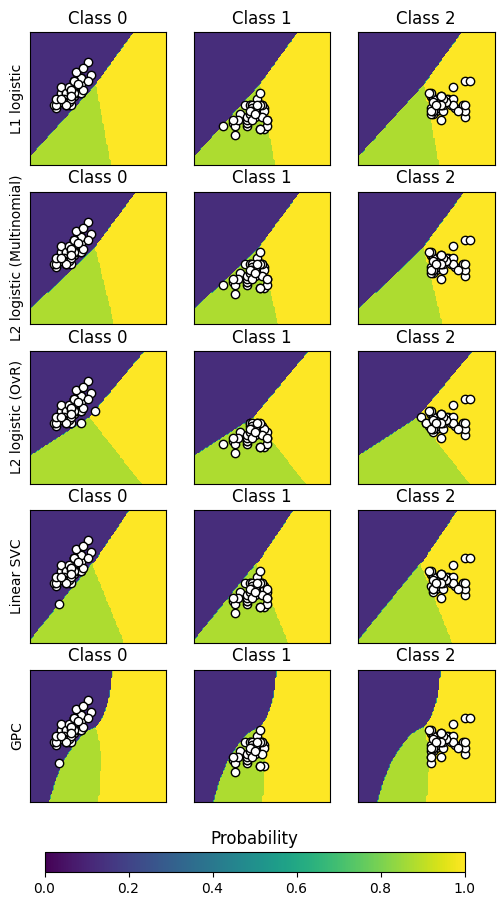

In [63]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

iris = datasets.load_iris()
X = iris.data[:, 0:2]  # we only take the first two features for visualization
y = iris.target

n_features = X.shape[1]

C = 10
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(
        C=C, penalty="l1", solver="saga", multi_class="multinomial", max_iter=10000
    ),
    "L2 logistic (Multinomial)": LogisticRegression(
        C=C, penalty="l2", solver="saga", multi_class="multinomial", max_iter=10000
    ),
    "L2 logistic (OvR)": LogisticRegression(
        C=C, penalty="l2", solver="saga", multi_class="ovr", max_iter=10000
    ),
    "Linear SVC": SVC(kernel="linear", C=C, probability=True, random_state=0),
    "GPC": GaussianProcessClassifier(kernel),
}

n_classifiers = len(classifiers)

fig, axes = plt.subplots(
    nrows=n_classifiers,
    ncols=len(iris.target_names),
    figsize=(3 * 2, n_classifiers * 2),
)
for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X, y).predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy (train) for {name}: {accuracy:0.1%}")
    for label in np.unique(y):
        # plot the probability estimate provided by the classifier
        disp = DecisionBoundaryDisplay.from_estimator(
    classifier,
    X,
    response_method="predict",
    class_of_interest=label,
    ax=axes[classifier_idx, label],
    vmin=0,
    vmax=1,
)

        axes[classifier_idx, label].set_title(f"Class {label}")
        # plot data predicted to belong to given class
        mask_y_pred = y_pred == label
        axes[classifier_idx, label].scatter(
            X[mask_y_pred, 0], X[mask_y_pred, 1], marker="o", c="w", edgecolor="k"
        )
        axes[classifier_idx, label].set(xticks=(), yticks=())
    axes[classifier_idx, 0].set_ylabel(name)

ax = plt.axes([0.15, 0.04, 0.7, 0.02])
plt.title("Probability")
_ = plt.colorbar(
    cm.ScalarMappable(norm=None, cmap="viridis"), cax=ax, orientation="horizontal"
)

plt.show()

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?

In [64]:
ObamaClintonReleases = pandas.read_csv('/content/drive/MyDrive/SOCI40133/data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame.

In [65]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [66]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [67]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [68]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [69]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [70]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [71]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents.

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean?

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [72]:
TFVects.shape

(1367, 11368)

We can save this in the dataframe to make things easier

In [73]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [74]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [75]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

<ipython-input-76-c9d2b7441e78>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
<ipython-input-76-c9d2b7441e78>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


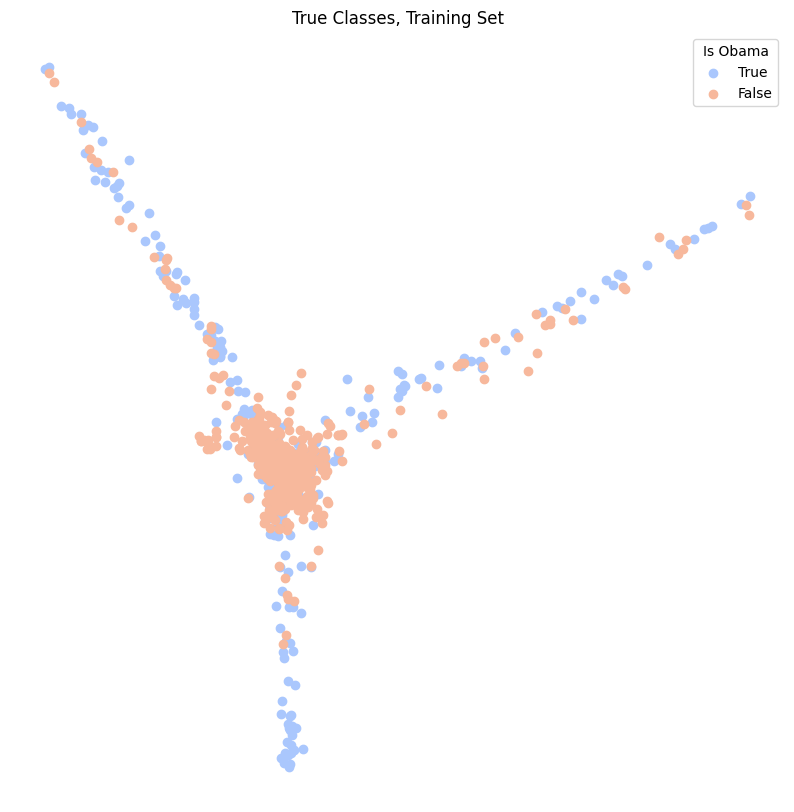

In [76]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

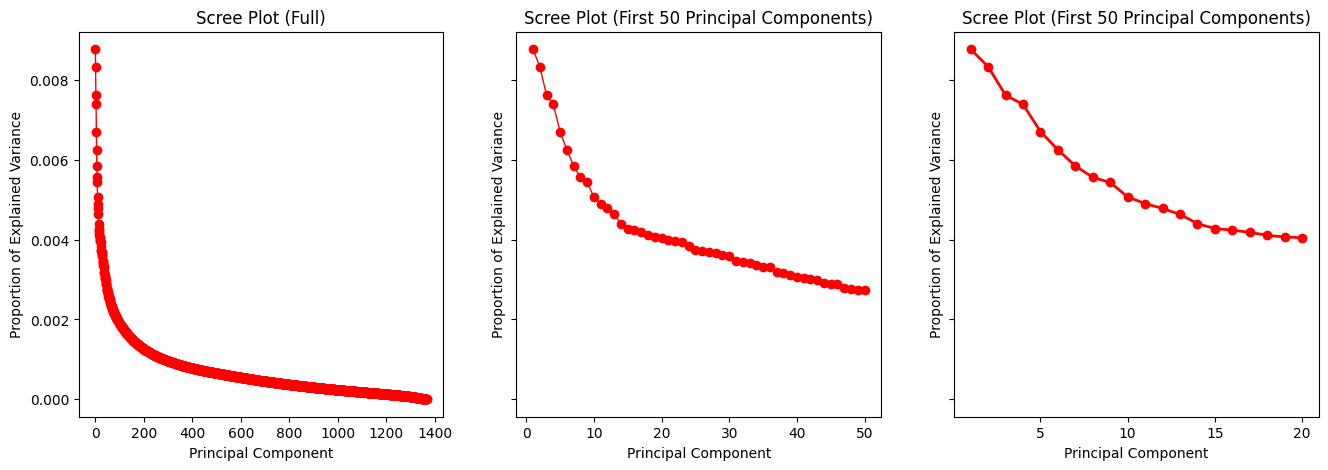

In [77]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [78]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [79]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [80]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6642282370153622

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [81]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6257309941520468

Slightly poorer. How about using more dimensions (40)?

In [82]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7446964155084126
Testing:
0.6842105263157895


Or still more (100)?

In [83]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8302852962692027
Testing:
0.7426900584795322


Or even more (200)!

In [84]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8653986832479883
Testing:
0.7602339181286549


This is becoming ridiculous (400)!

In [85]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9144111192392099
Testing:
0.7865497076023392


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [86]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9568397951719093


Train the model using training data, and then test it on the testing data.

In [87]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8011695906432749


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [88]:
ptt= pandas.read_csv('/content/drive/MyDrive/SOCI40133/PTTdata3.csv', index_col=0)

In [89]:
type(ptt)

pandas.core.frame.DataFrame

In [90]:
ptt

,看板,標題,日期,類型,內文
作者,,,,,
sky2030 (無業遊民),Boy-Girl,[心情] 出國巧遇台女趣事,2023-12,心情,最近常跟朋友一起跑胡志明，河內玩\n\n玩什麼就不要問了\n\n某天晚上 剛好在一間麵店吃飯...
iamjimhaha (磨刀霍霍向肥羊),Boy-Girl,[討論] 找台女不找外配是不是因為不想養？,2023-12,討論,\n發現有些台男\n明明就找不到對象\n卻不願意找外籍\n\n是否是因為找台女還能要求有工作...
Sugimoto5566 (馬丁),Boy-Girl,"[討論] 印度移工如果來台,台女會怎麼選?",2023-11,討論,未來的有一天\n\n如果印度的移工來到台灣\n\n街上勢必有更多印度男\n\n印度男有深邃的...
corydoras09 (),Boy-Girl,Re: [討論] 為何台女很少會主動認錯?,2023-11,討論,我有遇過那種我完全沒錯的女生\n死的都能掰成活的\n但那時候暈船暈的厲害\n所以一直舔\n現...
drinkmuffin (暢飲鬆餅),Boy-Girl,Re: [討論] 為何台女很少會主動認錯?,2023-11,討論,\n \n？？？\n我遇到的比較多是台男才少主動認錯吧？\n \n一推愛面子愛到不行 說話...
...,...,...,...,...,...
ChrisDavis (工業電風扇),Marginalman,Re: [閒聊] 台女果然優質,2024-01,閒聊,→ waitan: 你島棒球豚嘎器仔很多的 ...
Vedan (味丹),Marginalman,Re: [閒聊] 台女果然優質,2024-01,閒聊,\n這就惡性循環\n\n剛開始只有部分台男這樣\n\n然後讓部分台女食髓知味\n\n接著你本...
takashi001 (沙花叉クロヱ的狗),Marginalman,Re: [閒聊] 台女果然優質,2024-01,閒聊,確實\n\n與其看啦啦隊\n\n不如去交女朋友\n\n然後叫她穿拉拉隊服在你身上搖==\n\...


In [91]:


# 修改欄位名稱
ptt = ptt.rename(columns={'作者': 'user', '看板': 'board', '標題': 'title', '日期': 'date', '類型': 'type', '內文': 'text'})

# 顯示修改後的 DataFrame
print(ptt[:100:10])


                         board                              title     date  \
作者                                                                           
sky2030 (無業遊民)        Boy-Girl                      [心情] 出國巧遇台女趣事  2023-12   
smallgigi (爸爸)        Boy-Girl  Re: [討論] 台女會覺得外籍新娘是威脅嗎???????????  2023-11   
motivate (motivate)   Boy-Girl              [討論] 為什麼日女韓女比台女更願意生小孩  2023-11   
demitri (咻咻咻)         Boy-Girl          Re: [討論]為什麼日韓女生比台女更願意生小孩?  2023-07   
endurance (大家好)       Boy-Girl              [討論]為什麼日韓女生比台女更願意生小孩?  2023-07   
sumade (斬卍凱蒂貓卍佛)      Boy-Girl           Re: [討論] 台女自助餐是不是台男自己造成的  2023-05   
newheader (創這支店)      Boy-Girl             [討論] 追台女的養成都是送東西導致公主病？  2023-05   
a874622 (流浪者)         Boy-Girl             [討論] 女孩心中台女典範與男生一樣嗎???  2023-01   
CuLiZn5566 (同理心5566)  Boy-Girl             Re: [心情] 二手台女的價格只會越來越低  2023-01   
globetrot678 (環遊世界)   Boy-Girl                 [心情] 不喜歡長得醜的台女有錯嗎？  2022-12   

                     type                                      

In [92]:
import pandas as pd
import re

#remove url in text

def remove_urls_from_text(text):

    url_pattern = re.compile(r'https?://\S+|www\.\S+')


    text_without_urls = re.sub(url_pattern, '', text)

    return text_without_urls

ptt['text'] = ptt['text'].apply(remove_urls_from_text)

print(ptt)

                             board                  title     date type  \
作者                                                                        
sky2030 (無業遊民)            Boy-Girl          [心情] 出國巧遇台女趣事  2023-12   心情   
iamjimhaha (磨刀霍霍向肥羊)      Boy-Girl  [討論] 找台女不找外配是不是因為不想養？  2023-12   討論   
Sugimoto5566 (馬丁)         Boy-Girl  [討論] 印度移工如果來台,台女會怎麼選?  2023-11   討論   
corydoras09 ()            Boy-Girl  Re: [討論] 為何台女很少會主動認錯?  2023-11   討論   
drinkmuffin (暢飲鬆餅)        Boy-Girl  Re: [討論] 為何台女很少會主動認錯?  2023-11   討論   
...                            ...                    ...      ...  ...   
ChrisDavis (工業電風扇)     Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   
Vedan (味丹)             Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   
takashi001 (沙花叉クロヱ的狗)  Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   
wahaha99 (我討厭人類)       Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   
miHoYo (米哈遊)           Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   

                        

In [93]:
unique_values_set = set(ptt['board'])
print(unique_values_set)


{'C_Chat', 'Gossiping', 'HatePolitics', 'Marginalman', 'Boy-Girl'}


In [94]:
ptt['category'] = [s == 'Boy-Girl' for s in ptt['board']]

In [95]:
import jieba
import re
import pandas as pd

chinese_stopwords = set(['的', '了', '和', '是', '就', '都', '而', '及', '與', '著', '或', '時', '啊', '個', '在', '也'])

def chinese_normalize(text):
    tokens = jieba.lcut(text)
    tokens = [token for token in tokens if not re.match(r'^[\W\d]+$', token)]
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in chinese_stopwords]
    return ' '.join(tokens)

# Assuming you have a DataFrame named 'ptt'
ptt['tokenized'] = ptt['text'].apply(lambda x: jieba.lcut(x))
ptt['normalized'] = ptt['text'].apply(chinese_normalize)

# Display the results
print(ptt[:15])



Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 0.864 seconds.
DEBUG:jieba:Loading model cost 0.864 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


                         board                              title     date  \
作者                                                                           
sky2030 (無業遊民)        Boy-Girl                      [心情] 出國巧遇台女趣事  2023-12   
iamjimhaha (磨刀霍霍向肥羊)  Boy-Girl              [討論] 找台女不找外配是不是因為不想養？  2023-12   
Sugimoto5566 (馬丁)     Boy-Girl              [討論] 印度移工如果來台,台女會怎麼選?  2023-11   
corydoras09 ()        Boy-Girl              Re: [討論] 為何台女很少會主動認錯?  2023-11   
drinkmuffin (暢飲鬆餅)    Boy-Girl              Re: [討論] 為何台女很少會主動認錯?  2023-11   
geige ()              Boy-Girl              Re: [討論] 為何台女很少會主動認錯?  2023-11   
ga014388 (張儒)         Boy-Girl  Re: [討論] 台女會覺得外籍新娘是威脅嗎???????????  2023-11   
CuLiZn5566 (同理心5566)  Boy-Girl  Re: [討論] 台女會覺得外籍新娘是威脅嗎???????????  2023-11   
kobe8bryant (kobe)    Boy-Girl  Re: [討論] 台女會覺得外籍新娘是威脅嗎???????????  2023-11   
damm (S e t h)        Boy-Girl  Re: [討論] 台女會覺得外籍新娘是威脅嗎???????????  2023-11   
smallgigi (爸爸)        Boy-Girl  Re: [討論] 台女會覺得外籍新娘是威脅嗎??????????

In [96]:
holdBackFraction = .2
train_data_ptt_df, test_data_ptt_df = sklearn.model_selection.train_test_split(ptt, test_size=holdBackFraction)

In [97]:
print(len(train_data_ptt_df))
print(len(test_data_ptt_df))

2375
594


In [98]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=1, norm='l2')
TFVects_ptt = TFVectorizer.fit_transform(train_data_ptt_df['text'])

In [99]:
TFVects_ptt.shape

(2375, 10237)

In [100]:
import pandas as pd
import numpy as np

# Assuming train_data_ptt_df and TFVects are defined

# Get the number of rows to keep
num_rows_to_keep = TFVects.shape[0]

# Randomly sample rows from train_data_ptt_df
train_data_ptt_df_sampled = train_data_ptt_df.sample(n=num_rows_to_keep, random_state=42)

# Update the DataFrame with sampled rows
train_data_ptt_df = train_data_ptt_df_sampled

# Now, proceed with your TF-IDF transformation
TFVects = TFVectorizer.fit_transform(train_data_ptt_df['text'])
train_data_ptt_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

# Check the lengths to ensure they match
print(len(train_data_ptt_df))
print(TFVects.shape[0])


1367
1367


In [101]:
train_data_ptt_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [102]:
pca = sklearn.decomposition.PCA()
reduced_ptt_data = pca.fit_transform(np.stack(train_data_ptt_df['vect'], axis=0))

In [103]:
train_data_ptt_df['pca'] = [r for r in reduced_ptt_data]

<ipython-input-104-3603daeba901>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
<ipython-input-104-3603daeba901>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


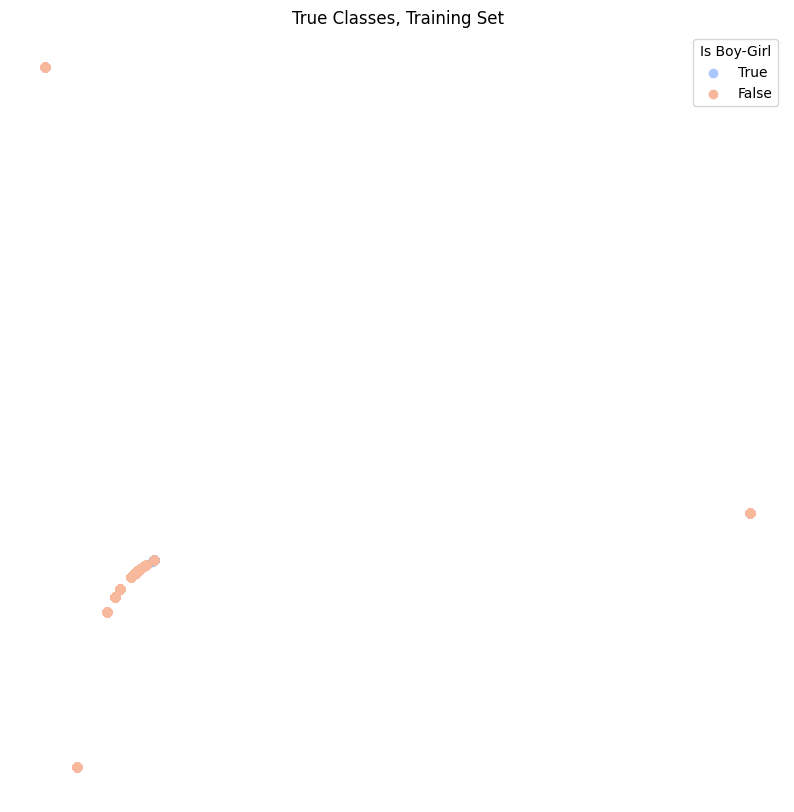

In [104]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_ptt_df[train_data_ptt_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_ptt_df[train_data_ptt_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Boy-Girl')
plt.title('True Classes, Training Set')
plt.show()

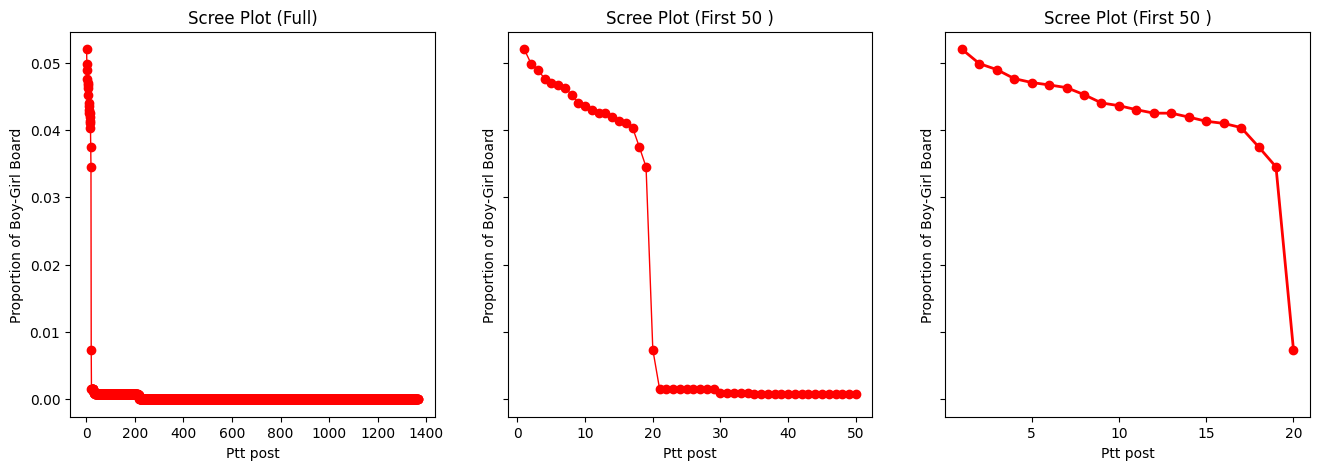

In [105]:
n_components = pca.n_components_

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 5), sharey=True)

eigen_vals = np.arange(n_components) + 1  # 修改此行
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Ptt post')
ax1.set_ylabel('Proportion of Boy-Girl Board')


eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 )')
ax2.set_xlabel('Ptt post')
ax2.set_ylabel('Proportion of Boy-Girl Board')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 )')
ax3.set_xlabel('Ptt post')
ax3.set_ylabel('Proportion of Boy-Girl Board')

plt.show()

In [106]:
train_data_ptt_df['pca_reduced_10'] = train_data_ptt_df['pca'].apply(lambda x: x[:10])

In [107]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_ptt_df['pca_reduced_10'], axis=0), train_data_ptt_df['category'])

LogisticRegression()

In [108]:
logistic.score(np.stack(train_data_ptt_df['pca_reduced_10'], axis=0), train_data_ptt_df['category'])

0.8763716166788588

In [109]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_ptt_df['text'])
test_data_ptt_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_ptt_df['vect'], axis=0))
test_data_ptt_df['pca'] = [r for r in reduced_data_test]
test_data_ptt_df['pca_reduced_10'] = test_data_ptt_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_ptt_df['pca_reduced_10'], axis=0), test_data_ptt_df['category'])

0.8787878787878788

In [110]:
train_data_ptt_df['pca_reduced_40'] = train_data_ptt_df['pca'].apply(lambda x: x[:40])
test_data_ptt_df['pca_reduced_40'] = test_data_ptt_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_ptt_df['pca_reduced_40'], axis=0), train_data_ptt_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_ptt_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_ptt_df['pca_reduced_40'], axis=0), test_data_ptt_df['category']))

Training:
0.5662033650329188
Testing:
0.8939393939393939


In [111]:
train_data_ptt_df['pca_reduced_100'] =train_data_ptt_df['pca'].apply(lambda x: x[:100])
test_data_ptt_df['pca_reduced_100'] = test_data_ptt_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_ptt_df['pca_reduced_100'], axis=0), train_data_ptt_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_ptt_df['pca_reduced_100'], axis=0), train_data_ptt_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_ptt_df['pca_reduced_100'], axis=0),test_data_ptt_df['category']))

Training:
0.9897585954645208
Testing:
0.9023569023569024


In [112]:
train_data_ptt_df['pca_reduced_200'] = train_data_ptt_df['pca'].apply(lambda x: x[:200])
test_data_ptt_df['pca_reduced_200'] = test_data_ptt_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_ptt_df['pca_reduced_200'], axis=0), train_data_ptt_df['category'])


print("Training:")
print(logistic.score(np.stack(train_data_ptt_df['pca_reduced_200'], axis=0), train_data_ptt_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_ptt_df['pca_reduced_200'], axis=0), test_data_ptt_df['category']))

Training:
0.9978054133138259
Testing:
0.9074074074074074


In [113]:
train_data_ptt_df['pca_reduced_400'] = train_data_ptt_df['pca'].apply(lambda x: x[:400])
test_data_ptt_df['pca_reduced_400'] = test_data_ptt_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_ptt_df['pca_reduced_400'], axis=0), train_data_ptt_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_ptt_df['pca_reduced_400'], axis=0), train_data_ptt_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_ptt_df['pca_reduced_400'], axis=0), test_data_ptt_df['category']))

Training:
1.0
Testing:
0.9107744107744108


In [114]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_ptt_df['vect'], axis=0), train_data_ptt_df['category'])
print(logistic_l1.score(np.stack(train_data_ptt_df['vect'], axis=0), train_data_ptt_df['category']))

1.0


In [115]:
print(logistic_l1.score(np.stack(test_data_ptt_df['vect'], axis=0),test_data_ptt_df['category']))

0.9107744107744108


# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


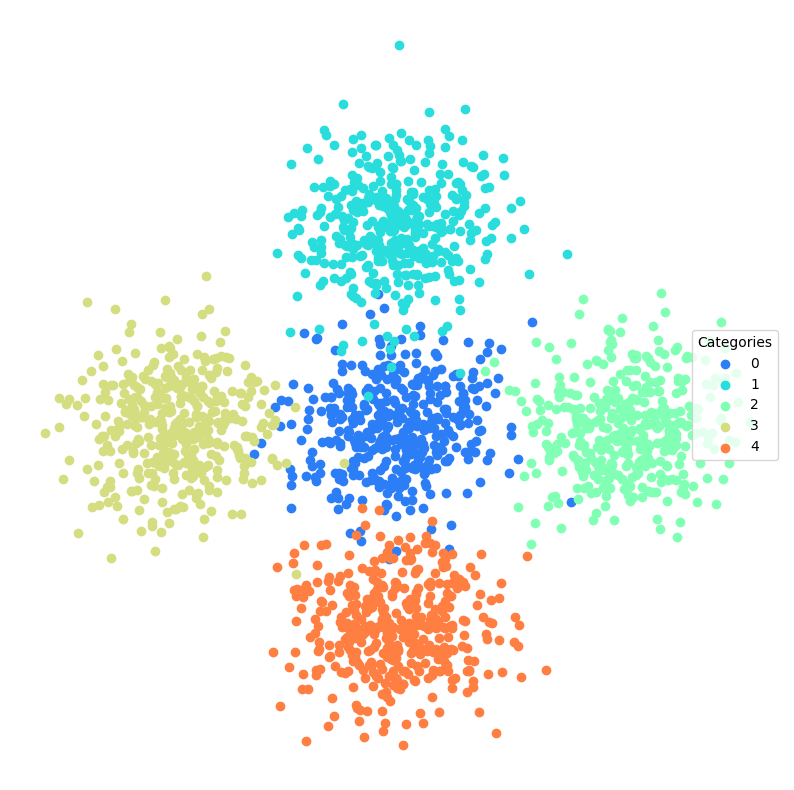

In [116]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [117]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


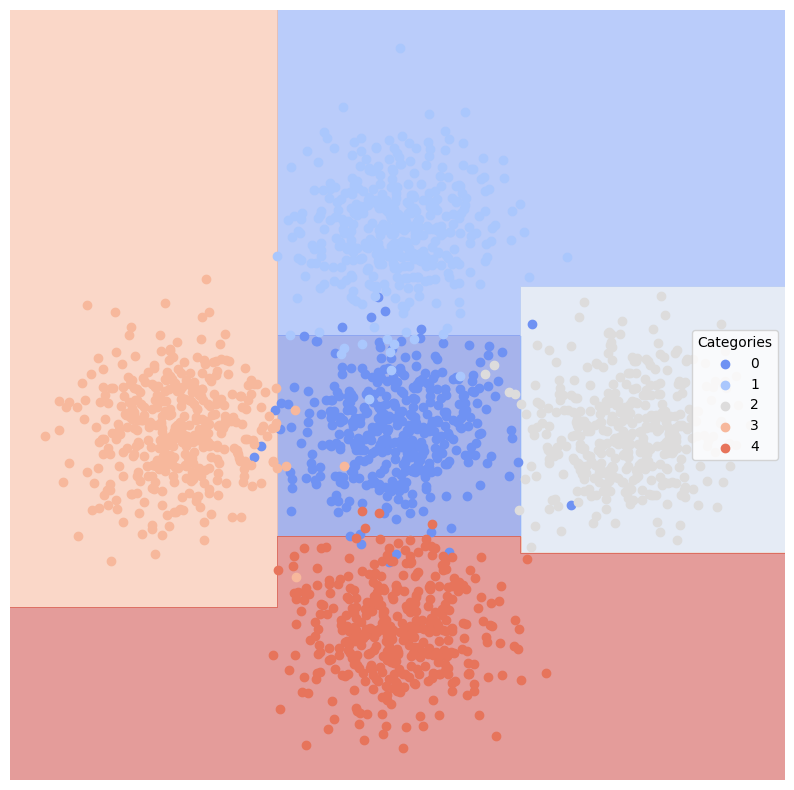

In [118]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [119]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.034,0.962524,0.872549,0.843020,0.956989
1,0.014,0.977155,0.971154,0.942158,0.961905
2,0.004,0.989691,1.000000,0.983381,0.979381
3,0.016,0.972393,0.970874,0.934642,0.952381
4,0.008,0.980000,1.000000,0.968000,0.960000


Lets look at accuracy:

In [120]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.962

What happens if we trim the tree?

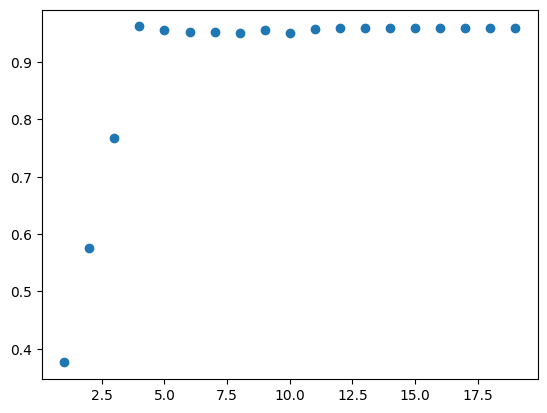

In [121]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [122]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [123]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


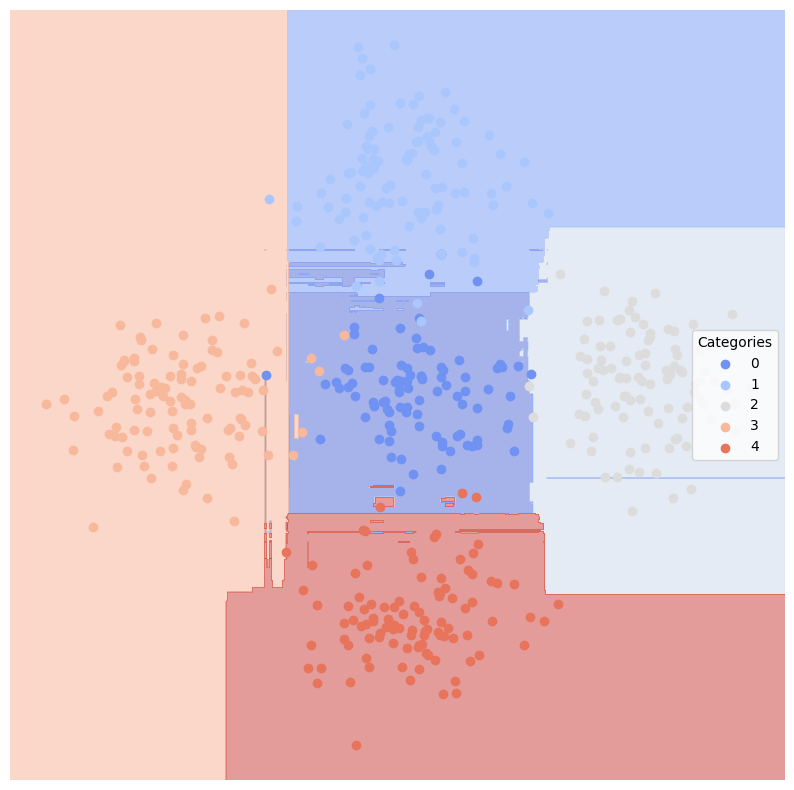

In [124]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [125]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.036,0.957148,0.871287,0.834444,0.946237
1,0.016,0.972393,0.970874,0.934642,0.952381
2,0.004,0.993605,0.989691,0.981488,0.989691
3,0.014,0.973659,0.980392,0.943707,0.952381
4,0.006,0.985000,1.000000,0.976000,0.970000


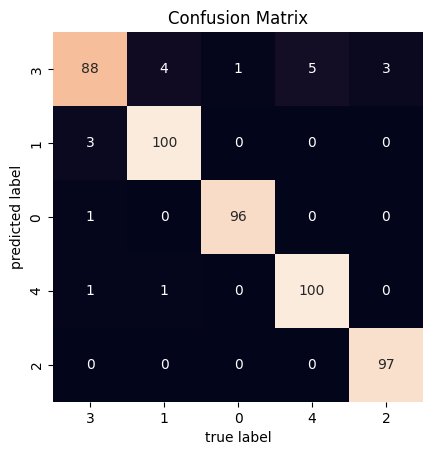

In [126]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


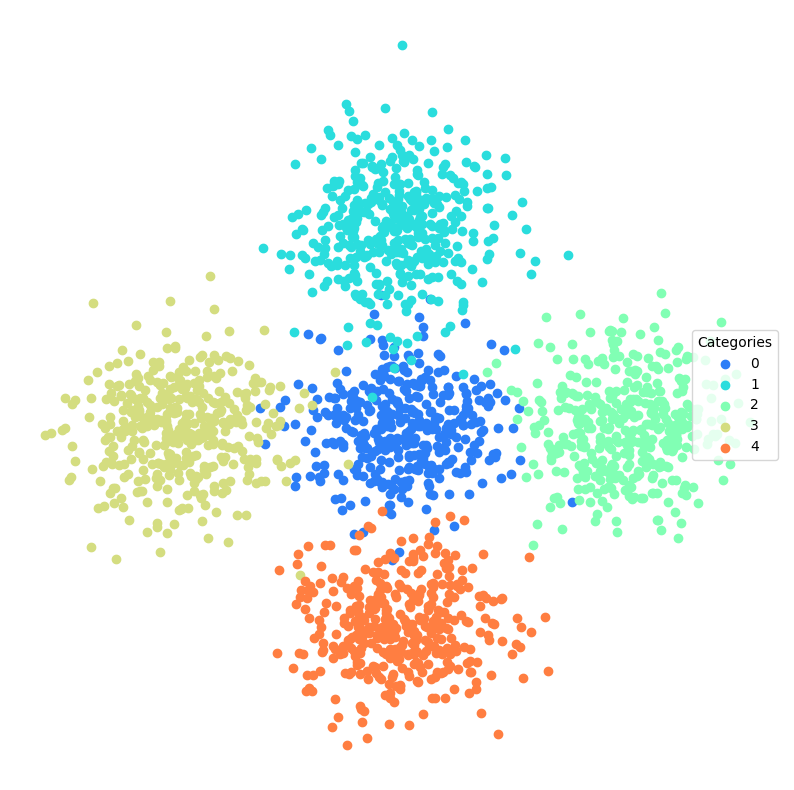

In [127]:
noise_df = lucem_illud.andSplit(noise=.2)
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

In [128]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


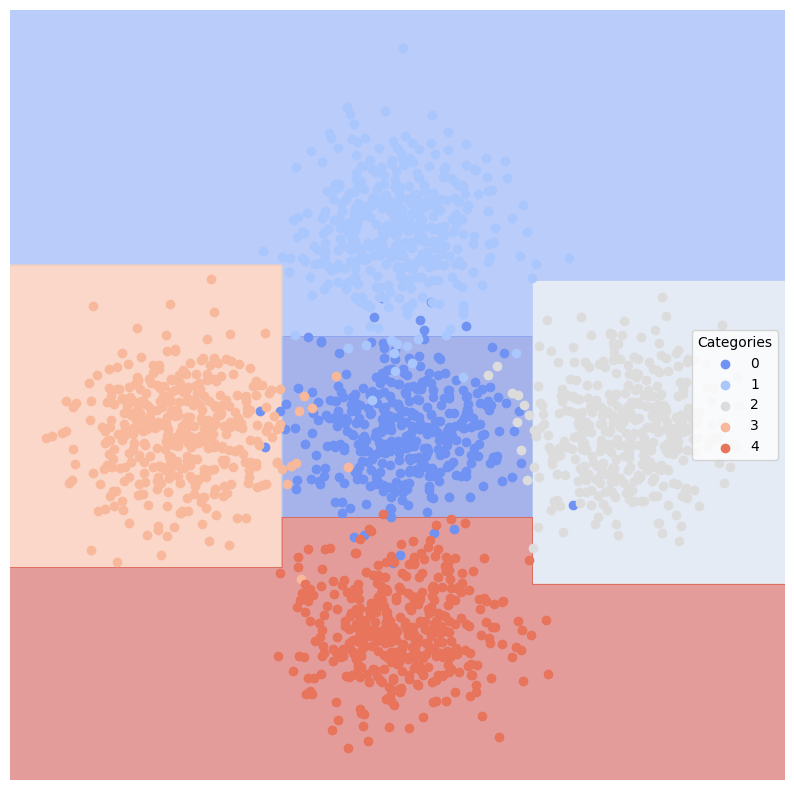

In [129]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [130]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.020,0.963473,0.970874,0.921359,0.934579
1,0.006,0.992167,0.978723,0.970199,0.989247
2,0.004,0.993554,0.989583,0.981275,0.989583
3,0.002,0.998775,0.989247,0.989247,1.000000
4,0.008,0.991670,0.973684,0.966991,0.991071


In [131]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.98

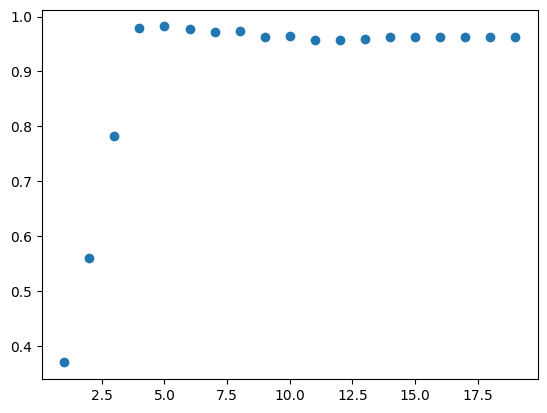

In [132]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [133]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [134]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


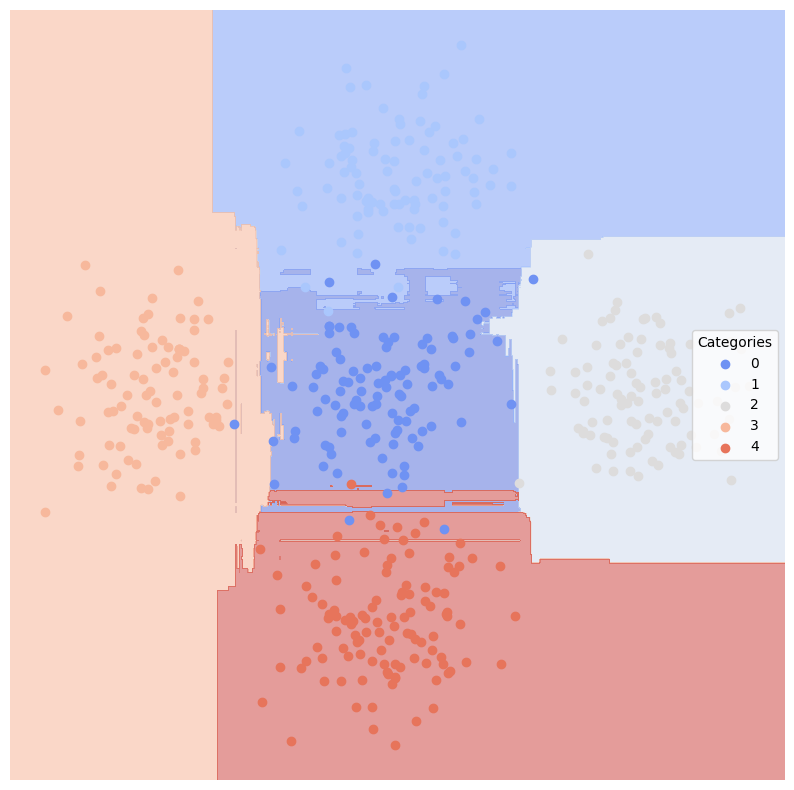

In [135]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [136]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.022,0.955399,0.980000,0.915570,0.915888
1,0.010,0.989710,0.958333,0.950029,0.989247
2,0.002,0.998762,0.989691,0.989691,1.000000
3,0.002,0.998775,0.989247,0.989247,1.000000
4,0.008,0.991670,0.973684,0.966991,0.991071


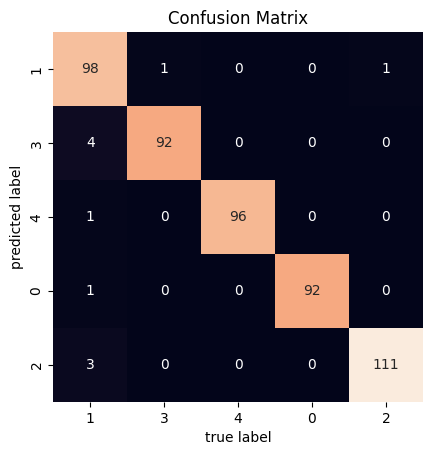

In [137]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [138]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '/content/drive/MyDrive/SOCI40133/data') #Free data to play with: documents from a newsgroup corpus. # replace path if on Colab
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [139]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [140]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [141]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [142]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [143]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [144]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
soc.religion.christian,0.285134,0.500000,0.000000,0.285134,0.000000
talk.religion.misc,0.177700,0.501539,0.285714,0.176683,0.006601
comp.graphics,0.720674,0.502870,0.264794,0.264766,0.975771
sci.space,0.283391,0.503550,0.333333,0.276977,0.029536


And lets look at the testing data

In [145]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.29466357308584684


Let's produce another confusion matrix:

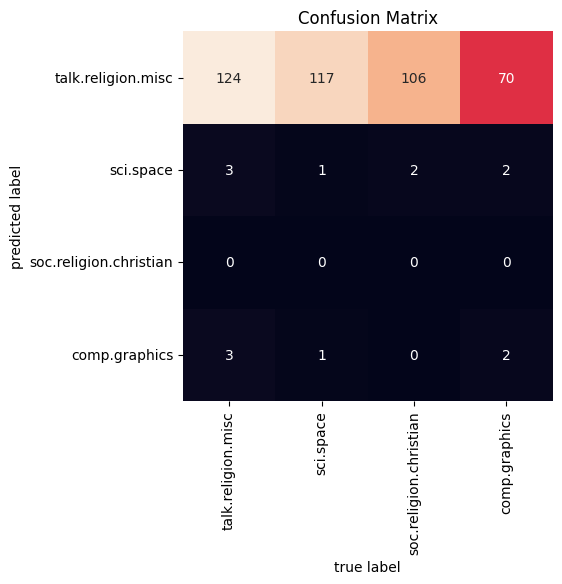

In [146]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [147]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [148]:
ptt_ex5= pandas.read_csv('/content/drive/MyDrive/SOCI40133/PTTdata3.csv', index_col=0)

ptt_ex5 =ptt_ex5.reset_index()

ptt_ex5= ptt_ex5.rename(columns={'作者': 'user', '看板': 'board', '標題': 'title', '日期': 'date', '類型': 'type', '內文': 'text'})
import pandas as pd
import re

#remove url in text

def remove_urls_from_text(text):

    url_pattern = re.compile(r'https?://\S+|www\.\S+')


    text_without_urls = re.sub(url_pattern, '', text)

    return text_without_urls

ptt_ex5['text'] =ptt_ex5['text'].apply(remove_urls_from_text)

print(ptt_ex5)
# 顯示修改後的 DataFrame
print(ptt_ex5[:100:10])


                       user        board                  title     date type  \
0            sky2030 (無業遊民)     Boy-Girl          [心情] 出國巧遇台女趣事  2023-12   心情   
1      iamjimhaha (磨刀霍霍向肥羊)     Boy-Girl  [討論] 找台女不找外配是不是因為不想養？  2023-12   討論   
2         Sugimoto5566 (馬丁)     Boy-Girl  [討論] 印度移工如果來台,台女會怎麼選?  2023-11   討論   
3            corydoras09 ()     Boy-Girl  Re: [討論] 為何台女很少會主動認錯?  2023-11   討論   
4        drinkmuffin (暢飲鬆餅)     Boy-Girl  Re: [討論] 為何台女很少會主動認錯?  2023-11   討論   
...                     ...          ...                    ...      ...  ...   
2964     ChrisDavis (工業電風扇)  Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   
2965             Vedan (味丹)  Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   
2966  takashi001 (沙花叉クロヱ的狗)  Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   
2967       wahaha99 (我討厭人類)  Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   
2968           miHoYo (米哈遊)  Marginalman        Re: [閒聊] 台女果然優質  2024-01   閒聊   

                           

In [149]:
unique_values_set = set(ptt_ex5['board'])
print(unique_values_set)

{'C_Chat', 'Gossiping', 'HatePolitics', 'Marginalman', 'Boy-Girl'}


In [150]:
unique_values_set = set(ptt_ex5['type'])
print(unique_values_set)

{'討論', '百合', '求助', '問卦', '問題', '心情', '新聞', '閒聊', '黑特', nan, '我推', '分享', '情報'}


In [151]:
ptt_ex5['type'] = ptt_ex5['type'].replace({'心情':'mood', '問題':'question', '百合':'les', '我推':'recom','討論':'discuss', '問卦':'ask_gossip', '新聞':'news', '黑特':'hate','求助':'help', '情報':'info', '閒聊':'chat', '分享':'share'})


In [152]:
ptt_ex5

,user,board,title,date,type,text
0,sky2030 (無業遊民),Boy-Girl,[心情] 出國巧遇台女趣事,2023-12,mood,最近常跟朋友一起跑胡志明，河內玩\n\n玩什麼就不要問了\n\n某天晚上 剛好在一間麵店吃飯...
1,iamjimhaha (磨刀霍霍向肥羊),Boy-Girl,[討論] 找台女不找外配是不是因為不想養？,2023-12,discuss,\n發現有些台男\n明明就找不到對象\n卻不願意找外籍\n\n是否是因為找台女還能要求有工作...
2,Sugimoto5566 (馬丁),Boy-Girl,"[討論] 印度移工如果來台,台女會怎麼選?",2023-11,discuss,未來的有一天\n\n如果印度的移工來到台灣\n\n街上勢必有更多印度男\n\n印度男有深邃的...
3,corydoras09 (),Boy-Girl,Re: [討論] 為何台女很少會主動認錯?,2023-11,discuss,我有遇過那種我完全沒錯的女生\n死的都能掰成活的\n但那時候暈船暈的厲害\n所以一直舔\n現...
4,drinkmuffin (暢飲鬆餅),Boy-Girl,Re: [討論] 為何台女很少會主動認錯?,2023-11,discuss,\n \n？？？\n我遇到的比較多是台男才少主動認錯吧？\n \n一推愛面子愛到不行 說話...
...,...,...,...,...,...,...
2964,ChrisDavis (工業電風扇),Marginalman,Re: [閒聊] 台女果然優質,2024-01,chat,→ waitan: 你島棒球豚嘎器仔很多的 ...
2965,Vedan (味丹),Marginalman,Re: [閒聊] 台女果然優質,2024-01,chat,\n這就惡性循環\n\n剛開始只有部分台男這樣\n\n然後讓部分台女食髓知味\n\n接著你本...
2966,takashi001 (沙花叉クロヱ的狗),Marginalman,Re: [閒聊] 台女果然優質,2024-01,chat,確實\n\n與其看啦啦隊\n\n不如去交女朋友\n\n然後叫她穿拉拉隊服在你身上搖==\n\...
2967,wahaha99 (我討厭人類),Marginalman,Re: [閒聊] 台女果然優質,2024-01,chat,\n雀食\n不過問題來了\n為什麼台男變這麼可悲\n\n全世界範圍\n好像台男特別可悲\n\...


In [153]:
board_categories = ['Marginalman', 'HatePolitics', 'Boy-Girl', 'C_Chat', 'Gossiping']

ptt_boardsDF = pd.DataFrame(columns=['text', 'board', 'type'])

for board_category in board_categories:
    board_data = ptt_ex5[ptt_ex5['board'] == board_category]
    ptt_boardsDF = ptt_boardsDF.append(board_data[['text', 'board', 'type']], ignore_index=True)

# 打印結果
print(ptt_boardsDF)

                                                   text        board  \
0             \n\n我嗑到了 好甜 這就是你們在VT裡面尋找的嗎\n\n我也找到了\n\n\n  Marginalman   
1     有誰\n\n我列一下會被狗的\n\n1.雨女\n\n2.小C\n\n3.噁蘿\n\n好了 誰...  Marginalman   
2     \n一時興起來買一沐日，\n\n前面來個台女一杯一杯慢慢點，\n\n點了十幾杯，\n\n幹霖...  Marginalman   
3     \n幹\n\n要是我自己就有出租屋了\n\n我幹嘛還租屋==\n\n媽的 這個月又被吸血\n...  Marginalman   
4        \n\n幹你娘\n狼師自承騙砲\n你們這些帥潮真的夠了\n到底要嘲諷我多久\n操雞掰\n\n  Marginalman   
...                                                 ...          ...   
2964  以下是gpt產生的新聞稿：\n\n112年9月6日臺灣新北地方法院一審宣判112年度審訴字第...    Gossiping   
2965  哈哈\n\n是我啦\n\n帥鴿鴨\n\n公司裡有個娘娘的男生\n\n小平頭 皮膚白  瘦瘦的...    Gossiping   
2966  好了啦，你就算這樣，也不會有正妹想跟你生小孩啦！\n\n我就不懂了，追正妹的自動工具人這麼多...    Gossiping   
2967  不是啊就算是台男也不會想養小孩吧\n寵物只要你愛牠餵牠帶牠出去玩\n牠也無條件愛你\n\n餵...    Gossiping   
2968  看到版上在討論未成年性行為的貼文\n\n很多31歲單身台女說，\n\n「未成年怎麼可以談戀愛...    Gossiping   

            type  
0           chat  
1            NaN  
2           chat  
3           chat  
4           chat  
...          ...  
29

In [154]:
import jieba
import re
import pandas as pd

chinese_stopwords = set(['的', '了', '和', '是', '就', '都', '而', '及', '與', '著', '或', '時', '啊', '個', '在', '也'])

def chinese_normalize(text):
    tokens = jieba.lcut(text)
    tokens = [token for token in tokens if not re.match(r'^[\W\d]+$', token)]
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in chinese_stopwords]
    return ' '.join(tokens)

ptt_boardsDF['tokenized'] = ptt_boardsDF['text'].apply(lambda x: jieba.lcut(x))
ptt_boardsDF['normalized'] = ptt_boardsDF['text'].apply(chinese_normalize)

# Display the results
print(ptt_boardsDF[:15])



                                                 text        board  type  \
0           \n\n我嗑到了 好甜 這就是你們在VT裡面尋找的嗎\n\n我也找到了\n\n\n  Marginalman  chat   
1   有誰\n\n我列一下會被狗的\n\n1.雨女\n\n2.小C\n\n3.噁蘿\n\n好了 誰...  Marginalman   NaN   
2   \n一時興起來買一沐日，\n\n前面來個台女一杯一杯慢慢點，\n\n點了十幾杯，\n\n幹霖...  Marginalman  chat   
3   \n幹\n\n要是我自己就有出租屋了\n\n我幹嘛還租屋==\n\n媽的 這個月又被吸血\n...  Marginalman  chat   
4      \n\n幹你娘\n狼師自承騙砲\n你們這些帥潮真的夠了\n到底要嘲諷我多久\n操雞掰\n\n  Marginalman  chat   
5   \n\n綜合法新社和路透社報導，美國億萬富豪馬斯克（Elon Musk）29日在社群媒體平台...  Marginalman  chat   
6   \n沒錯\n\n噁蘿就是版本破壞者\n\n而且他個性又好\n\n不會像一堆死台女一樣\n\n...  Marginalman  chat   
7   突然又想到\n\n接著剛剛那篇\n\n我少考慮一個可能性\n\n就是爛蓋沈迷二次元然後又想要...  Marginalman  chat   
8   \n\n話說我覺得台灣啦啦隊文化真的有點奇葩，因為國外運動啦啦隊都是配角中的配角，像我看\n...  Marginalman  chat   
9   \n其實我在某主辦的網紅見面會群組裡也看到有人三觀超正確\n某某人發廚說下次沒有請誰誰誰就要...  Marginalman  chat   
10  畢竟女生一輩子不嫁不會怎樣，不嫁還比較有市場\n\n普女不挑的玩夠了，最後還能搞回收\n\n...  Marginalman  chat   
11        我一向都是最認真拜讀丹哥的文章的\n\n\n媽的 我就知道\n\n又是噁蘿在搞\n\n  Marginalman  chat   
12  \n其實這就像你

In [1]:
ptt_boardsDF[:5]

NameError: name 'ptt_boardsDF' is not defined

In [156]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(ptt_boardsDF, test_size=holdBackFraction)

In [157]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [158]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [159]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['board'])

KNeighborsClassifier(n_neighbors=15)

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['board']))

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('/content/drive/MyDrive/SOCI40133/data/reddit.csv', index_col = 0) # replace path if on Colab

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $z = w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $f(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" style="width:500px">

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [ ]:
newsgroupsDF

In [ ]:
newsTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
newsTFVects = newsTFVectorizer.fit_transform([' '.join(l) for l in newsgroupsDF['normalized_text']])
newsgroupsDF['vect'] = [np.array(v).flatten() for v in newsTFVects.todense()]

In [ ]:
holdBackFraction = .2
train_newsgroupsDF, test_newsgroupsDF = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_newsgroupsDF['vect'], axis=0), train_newsgroupsDF['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_newsgroupsDF)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_newsgroupsDF)

In [ ]:
lucem_illud.plotregions(clf_svm, test_newsgroupsDF)

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_newsgroupsDF['vect'], axis=0), train_newsgroupsDF['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_newsgroupsDF)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_newsgroupsDF)

In [ ]:
lucem_illud.plotregions(clf_nn, test_newsgroupsDF)

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [pytorch version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/pytorch/text-classification/run_glue.py) and
[pytorch-lightning version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/pytorch-lightning/run_glue.py)(legacy) or
[tensorflow version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/tensorflow/text-classification/run_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/question-answering/run_squad.py) (legacy) script.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("women are stupid")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "So I would like to ask everyone, are Japanese girls more suitable for getting to know and dating than Taiwanese girls?"
sequence_1 = "Just so he can show off when he goes out"
sequence_2 = "HIf you don't work and spend your husband's money after you get married, doesn't it mean that your husband pays you a salary and is your boss???"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
Most people think that Japanese women look weaker than Taiwanese women, but this is actually a bit of a cultural misunderstanding.
I haven’t watched Japanese dramas, and the images I usually receive of Japanese girls come from AV and Japanese girl groups that appear in the news (singers like AKB48 look more kawaii).
If you actually go there, you will find that Japanese women and Taiwanese women are the same. What is the difference if they are both women? They also go shopping and take photos, and like to put on makeup and dress up beautifully.
They are a little petite in height, but they are also very serious about their work (service industry).
Conclusion: Speaking softly and softly should be the feeling of Japanese to foreigners, as well as the polite characteristics of the Japanese nation, plus many Japanese girls are really small, so they feel this way.
Taking care of your husband and raising children after marriage should be influenced by male chauvinism. I believe that many single and unmarried women are also very independent..
"""
questions = [
    "what singers mentions?",
    "hows their attitude about their work?",
    "What is the conclusion?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")